In [1]:
# Importar las bibliotecas necesarias
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR

Número de filas y columnas: (2557, 1) 

Tipo de datos:
 Load    int64
dtype: object 

Head:
                   Load
Date                  
2015-01-01  5686686080
2015-01-02  6752007030
2015-01-03  6605796020
2015-01-04  6273091530
2015-01-05  6760770300 



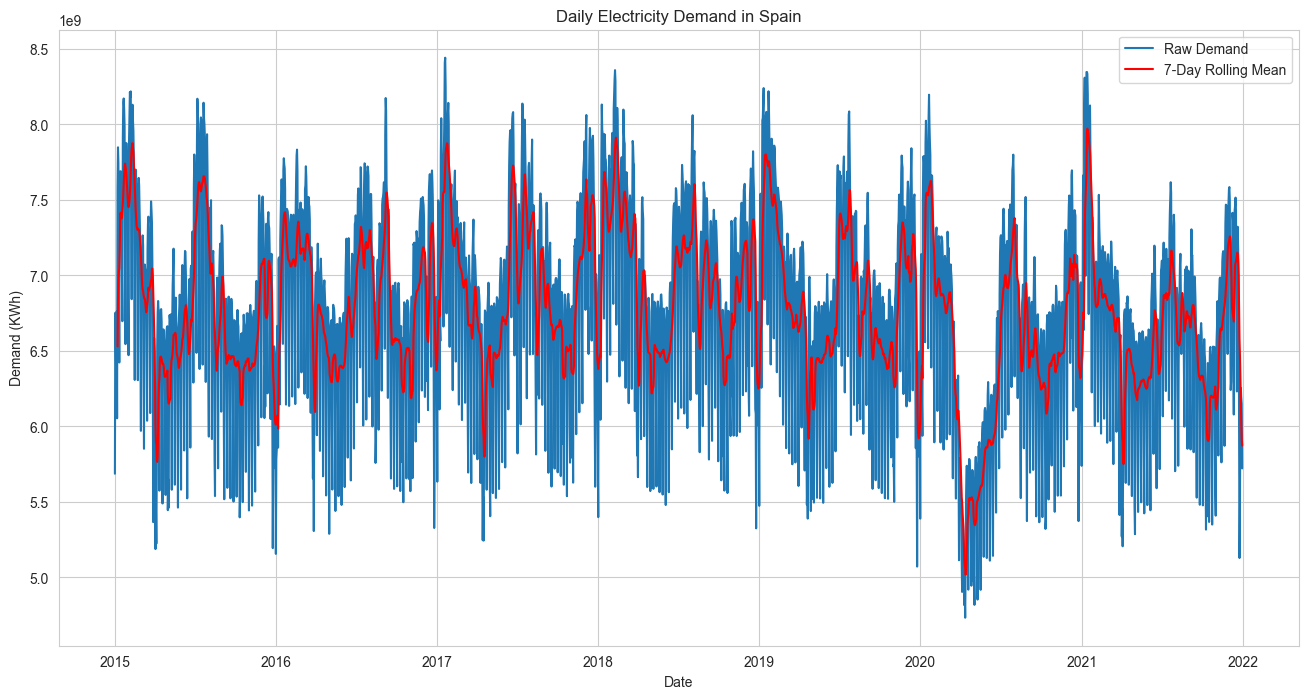

In [2]:
# Load dataset
path = os.getcwd()
fichero_DemandaDiaria = os.path.join(path, 'DemandaDiaria_KWh_2015-2021.csv')

# Read the data
data = pd.read_csv(fichero_DemandaDiaria, sep=";")
# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')

# Check the data
print("Número de filas y columnas:", data.shape, "\n")
print("Tipo de datos:\n", data.dtypes, "\n")
print("Head:\n", data.head(), "\n")

# Graph the data
sns.set_style("whitegrid")
rolling_mean = data['Load'].rolling(window=7).mean()
plt.figure(figsize=(16, 8))
plt.title('Daily Electricity Demand in Spain')
plt.xlabel('Date')
plt.ylabel('Demand (KWh)')
plt.plot(data.index, data['Load'], label='Raw Demand')
plt.plot(data.index, rolling_mean, color='red', label='7-Day Rolling Mean')
plt.legend(loc='best')
plt.show()

In [3]:
# Standardize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Load'].values.reshape(-1, 1))

# Split the data into training and test sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size, :]
test_data = scaled_data[train_size:, :]

# Create sequences of length 'sequence_length' to use as input data
def create_sequences(dataset, sequence_length_scope):
    X, y = [], []
    # Iterate over the dataset and create sequences of length 'sequence_length'
    for i in range(len(dataset) - sequence_length_scope):
        # Add a sequence of length 'sequence_length' to X
        X.append(dataset[i:i + sequence_length_scope, 0])
        # Add the next data point after each sequence of length 'sequence_length' to y
        y.append(dataset[i + sequence_length_scope, 0])
    # Convert list to array
    return np.array(X), np.array(y)

sequence_length = 10  # Length of the sequence for each input point
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Check the shape of the training sequences
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2035, 10)
y_train shape: (2035,)
X_test shape: (502, 10)
y_test shape: (502,)


In [4]:
# Function to train and evaluate SVR model with a given set of parameters
def SVM_linear(return_predictions=False):
    svr = SVR(kernel='linear', verbose = False)
    svr.fit(X_train, y_train)
    y_pred = svr.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    if return_predictions:
        return mse, y_pred
    else:
        return mse

In [5]:
# Function to train and evaluate SVR model with a given set of parameters
def SVM_poly(return_predictions=False):
    svr = SVR(kernel='poly', verbose = False)
    svr.fit(X_train, y_train)
    y_pred = svr.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    if return_predictions:
        return mse, y_pred
    else:
        return mse

In [6]:
# Function to train and evaluate SVR model with a given set of parameters
def SVM_sigmoid(return_predictions=False):
    svr = SVR(kernel='sigmoid',verbose = False)
    svr.fit(X_train, y_train)
    y_pred = svr.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    if return_predictions:
        return mse, y_pred
    else:
        return mse

In [7]:
# Function to train and evaluate SVR model with a given set of parameters
def SVM_rbf(return_predictions=False):
    svr = SVR(kernel='rbf', verbose = False)
    svr.fit(X_train, y_train)
    y_pred = svr.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    if return_predictions:
        return mse, y_pred
    else:
        return mse

In [16]:
# List of SVM kernels to optimize
kernels = [
    ("linear", SVM_linear(return_predictions=True)),
    ("poly", SVM_poly(return_predictions=True)),
    # ("sigmoid", SVM_sigmoid(return_predictions=True)),
    ("rbf", SVM_rbf(return_predictions=True))
]

# Best parameters for each kernel
best_mse = {}
best_predictions = {}

# Iterate over the kernels
for kernel, function in kernels:
    best_mse[kernel], best_predictions[kernel] = function
    
# Ensemble predictions
y_pred_ensemble = np.mean([best_predictions[kernel[0]] for kernel in kernels], axis=0)
mse_ensemble = mean_squared_error(y_test, y_pred_ensemble)

In [18]:
# Invert the normalization for y_pred and y_test for each kernel and the ensemble
y_pred_original = {}
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

for kernel in kernels:
    y_pred_original[kernel[0]] = scaler.inverse_transform(best_predictions[kernel[0]].reshape(-1, 1))
    
y_pred_original['ensemble'] = scaler.inverse_transform(y_pred_ensemble.reshape(-1, 1))

# Calculate MAE 
mae = {}
for kernel in kernels:
    mae[kernel[0]] = mean_absolute_error(y_test_original, y_pred_original[kernel[0]])
mae['ensemble'] = mean_absolute_error(y_test_original, y_pred_original['ensemble'])

# Calculate RMSE
rmse = {}
for kernel in kernels:
    rmse[kernel[0]] = np.sqrt(mean_squared_error(y_test_original, y_pred_original[kernel[0]]))
rmse['ensemble'] = np.sqrt(mean_squared_error(y_test_original, y_pred_original['ensemble']))

# Calculate MRAE (Mean Absolute Percentage Error)
mrae = {}
for kernel in kernels:
    mrae[kernel[0]] = np.mean(np.abs((y_test_original - y_pred_original[kernel[0]]) / y_test_original)) * 100
mrae['ensemble'] = np.mean(np.abs((y_test_original - y_pred_original['ensemble']) / y_test_original)) * 100

# Print metrics
for kernel in kernels:
    print(f"{kernel[0]} Metrics:")
    print('MAE: {:,.2f}'.format(mae[kernel[0]]))
    print('RMSE: {:,.2f}'.format(rmse[kernel[0]]))
    print('MRAE: {:,.2f}'.format(mrae[kernel[0]]))
    print("----------------------")

# Print metrics for the ensemble
print("Ensemble Metrics:")
print('MAE: {:,.2f}'.format(mae['ensemble']))
print('RMSE: {:,.2f}'.format(rmse['ensemble']))
print('MRAE: {:,.2f}'.format(mrae['ensemble']))
print("----------------------")


linear Metrics:
MAE: 196,577,881.54
RMSE: 277,442,078.94
MRAE: 3.05
----------------------
poly Metrics:
MAE: 246,522,306.23
RMSE: 315,115,974.15
MRAE: 3.72
----------------------
rbf Metrics:
MAE: 200,759,771.23
RMSE: 270,069,054.45
MRAE: 3.06
----------------------
Ensemble Metrics:
MAE: 183,059,920.79
RMSE: 249,186,966.52
MRAE: 2.82
----------------------


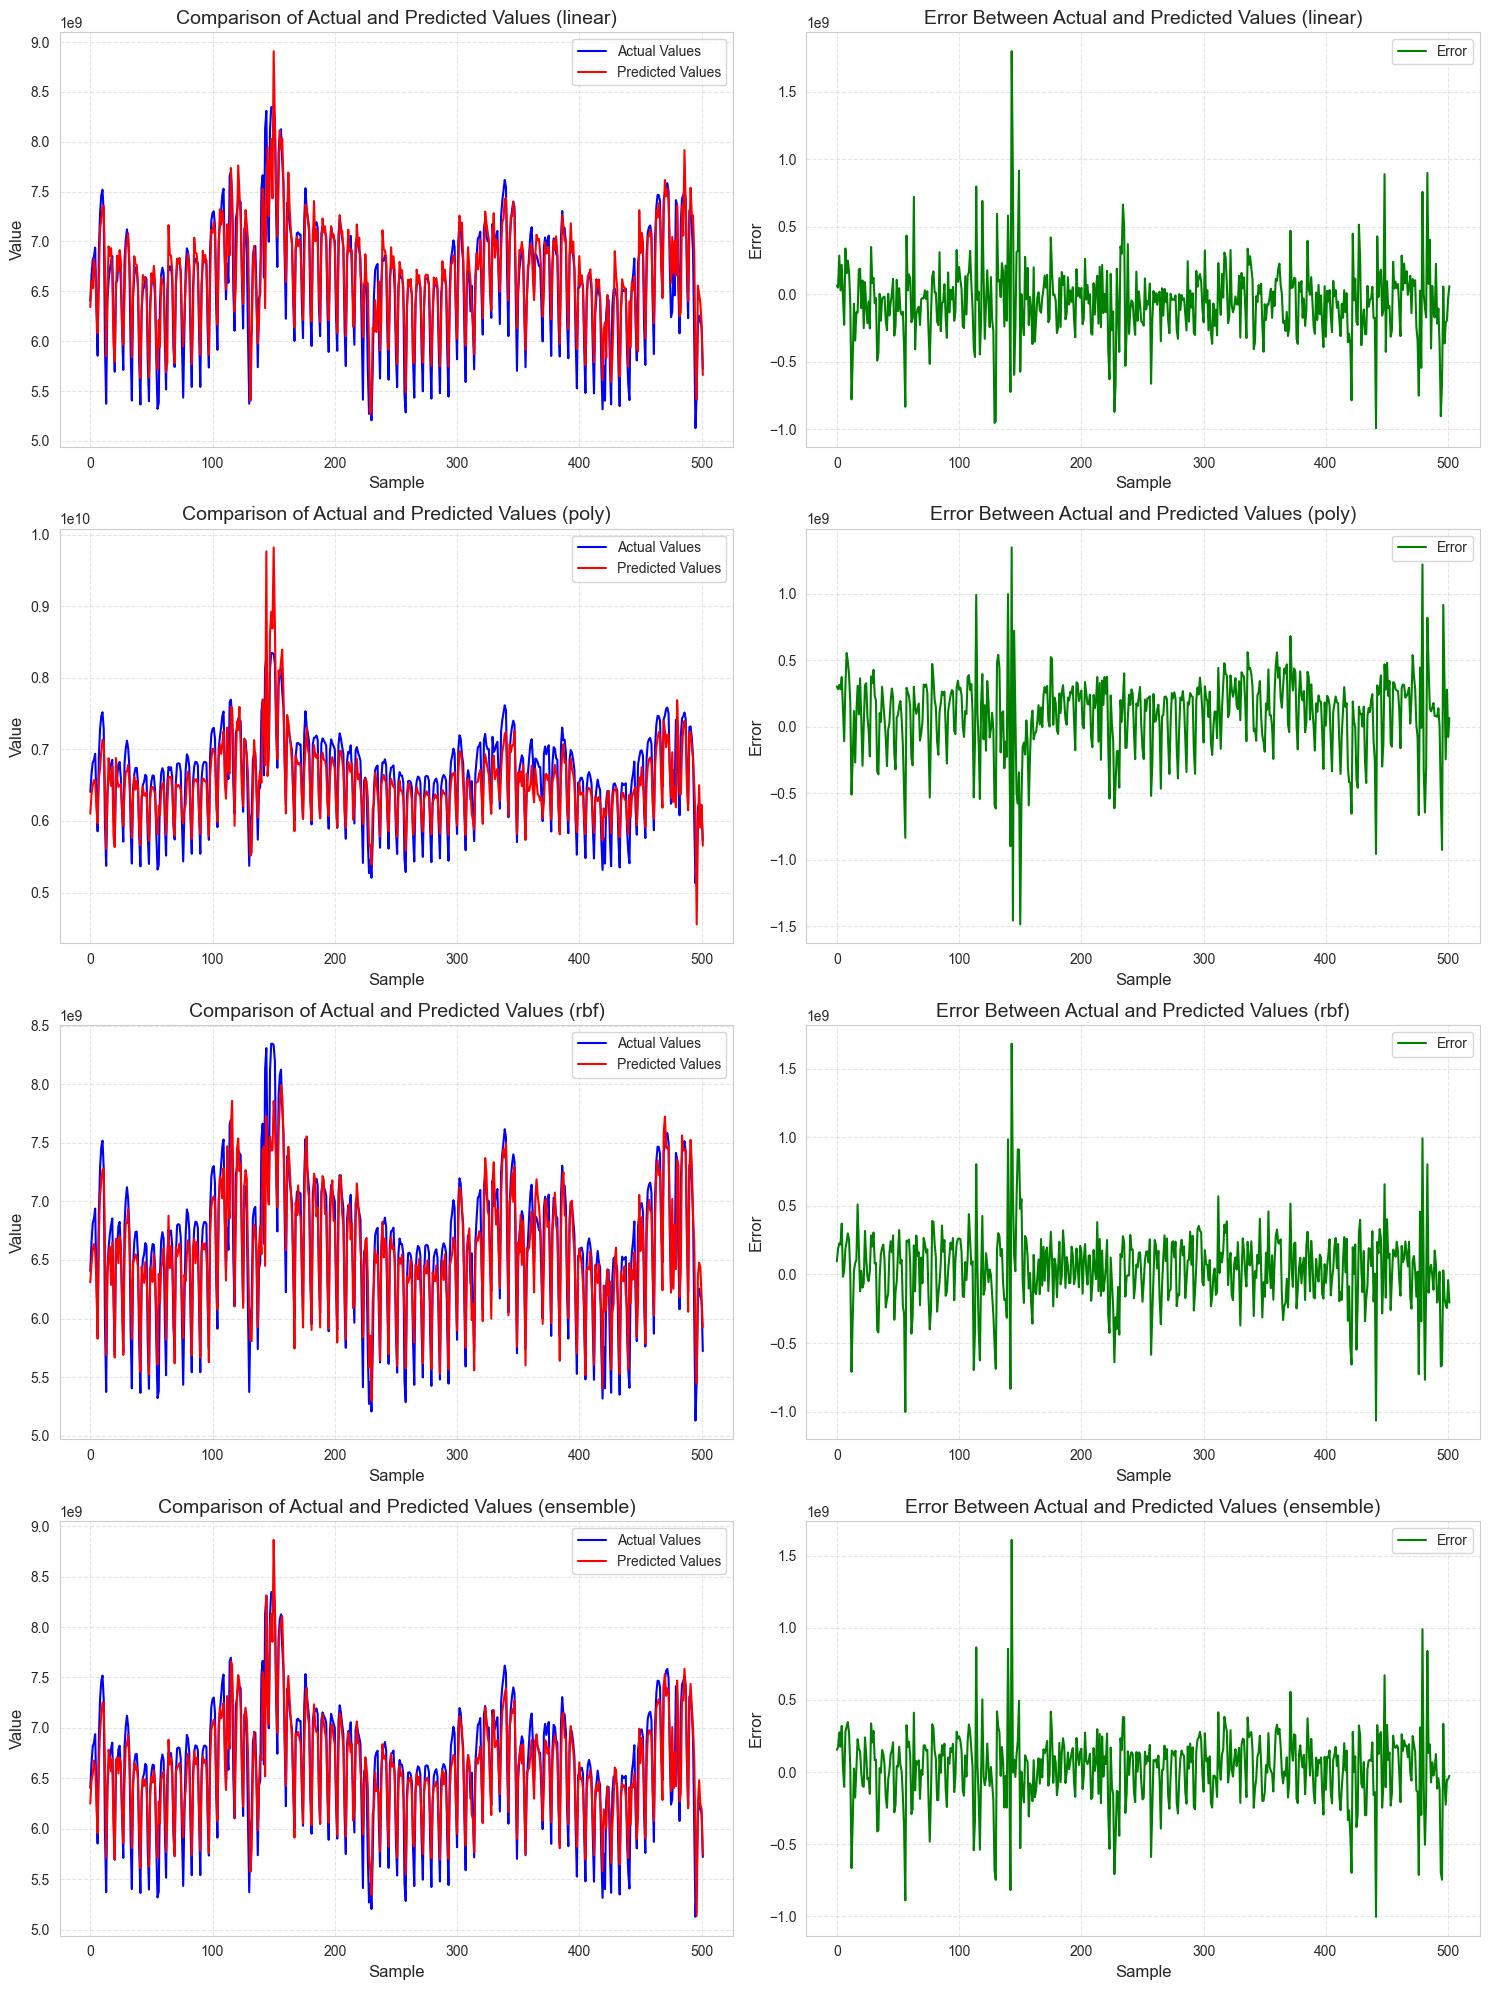

In [19]:
# Create a figure and a set of subplots for each kernel
n_kernels = len(kernels) + 1  # Including the ensemble
fig, axes = plt.subplots(n_kernels, 2, figsize=(15, 5 * n_kernels))

# Iterate over the kernels and ensemble
for idx, kernel in enumerate(kernels + [('ensemble', None)]):  # Adding ensemble to the list
    kernel_name = kernel[0]

    # Calculate the error between actual and predicted values
    error = y_test_original - y_pred_original[kernel_name]

    # Plot the actual vs predicted values
    axes[idx, 0].plot(y_test_original, label='Actual Values', color='blue')
    axes[idx, 0].plot(y_pred_original[kernel_name], label='Predicted Values', color='red')
    axes[idx, 0].set_xlabel('Sample', fontsize=12)
    axes[idx, 0].set_ylabel('Value', fontsize=12)
    axes[idx, 0].set_title(f'Comparison of Actual and Predicted Values ({kernel_name})', fontsize=14)
    axes[idx, 0].legend(fontsize=10)
    axes[idx, 0].grid(True, linestyle='--', alpha=0.5)

    # Plot the error
    axes[idx, 1].plot(error, label='Error', color='green')
    axes[idx, 1].set_xlabel('Sample', fontsize=12)
    axes[idx, 1].set_ylabel('Error', fontsize=12)
    axes[idx, 1].set_title(f'Error Between Actual and Predicted Values ({kernel_name})', fontsize=14)
    axes[idx, 1].legend(fontsize=10)
    axes[idx, 1].grid(True, linestyle='--', alpha=0.5)

# Adjust the layout and show the plots
plt.tight_layout()
plt.show()

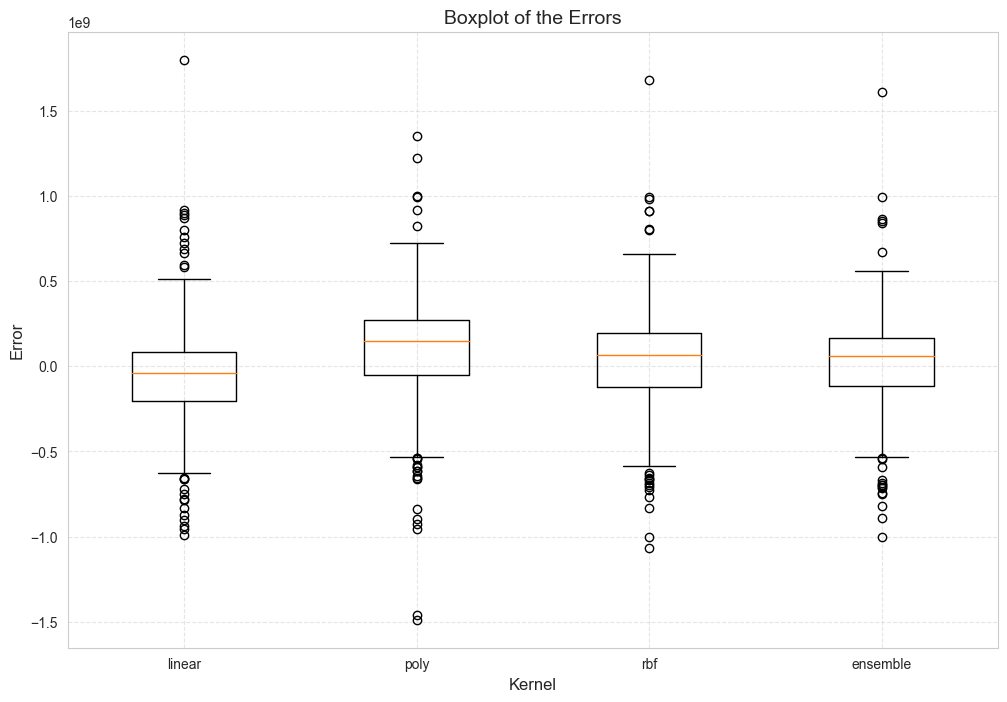

In [20]:
# Boxplot of the errors for all kernels
fig, ax = plt.subplots(figsize=(12, 8))

errors = [(y_test_original.flatten() - y_pred_original[kernel[0]].flatten()) for kernel in kernels]
errors.append(y_test_original.flatten() - y_pred_original['ensemble'].flatten())  # Including the ensemble error

ax.boxplot(errors)
ax.set_xticklabels([kernel[0] for kernel in kernels] + ['ensemble'])
ax.set_xlabel('Kernel', fontsize=12)
ax.set_ylabel('Error', fontsize=12)
ax.set_title('Boxplot of the Errors', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.5)

plt.show()